In [2]:
# importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from plotly import express as px
from plotly import graph_objects as go

In [4]:
def to_lower_case_with_underscores(string: str) -> str:
  """
  Return the string in lower case with underscores format.
  """
  words_to_remove = [" de ", " da ", " dos ", " das ", " "]
  for word in words_to_remove:
    string = string.replace(word,"_")
  return string.lower()



# Analise de dados do PNAD 2015

Fonte:
https://www.ibge.gov.br/estatisticas/sociais/populacao/9127-pesquisa-nacional-por-amostra-de-domicilios.html?=&t=o-que-e

## Definição do problema

- Analisar a distribuição de renda

Planejamento

# Fases de uma pesquisa estatística

## Definição do problema
- Principal fase de uma pesquisa.
- O problema muitas das vezes vem como uma dor

## Planejamento
- Definir o que precisa ser feito.
- Definir onde conseguir os dados.
- Definir quais ferramentas utilizar.
- Analisar a distribuição de renda da amostra
- Google Colab
- Dados obtidos do PNAD de 2015

## Coleta de dados
- Entender como os dados são coletados e de onde vieram.
- Entender vieses durante a coleta.
- Entender se é necessário mais dados.
- Exemplo. Formulários anônimos podem tornar os dados mais ou menos confiáveis.



## Crítica dos dados
- Garantir a integridade dos dados
- Observar se há dados anômolos

## Apuração dos dados
- Revisar se os dados resolvem os problemas
- Revisar se há dados faltantes
- Revisar a necessidade dos dados obtidos

## Apresentação dos dados
- Apresentar os dados conforme o público alvo
- Storytelling

## Análise e Interpretação dos dados
- Converter a análise estatística em um contexto de negócio
- Obter insights

## Objetivos

- Identificar a distribuição de renda
- Categorizar a renda por classes A, B, C, ...
- Testar se os homens recebem, em média, mais que as mulheres
- Verificar a correlação da renda com os anos de estudo

In [5]:
# leitura dos dados
dict_columns = {
    "Sexo" : "string",
    "Idade": "int",
    "Cor": "string",
    "Anos de Estudo": "int",
    "Renda": "float",
    "Altura": "float",
}

dados = pd.read_excel("/content/drive/MyDrive/data/ibge2015.xlsx", dtype=dict_columns)
dados.head(10)

,Sexo,Idade,Cor,Anos de Estudo,Renda,Altura
0,Masculino,23,Parda,12,800.0,1.603808
1,Feminino,23,Branca,12,1150.0,1.739790
2,Feminino,35,Parda,15,880.0,1.760444
3,Masculino,46,Branca,6,3500.0,1.783158
4,Feminino,47,Parda,9,150.0,1.690631
5,Feminino,34,Parda,12,790.0,1.637906
6,Masculino,57,Parda,12,3150.0,1.570078
7,Feminino,60,Parda,12,1700.0,1.608495
8,Feminino,50,Preta,14,1800.0,1.780329
9,Masculino,26,Parda,12,1150.0,1.793203


In [6]:
# convertendo o nome das colunas do dataframe para lower case with underscores
dados.rename(
    columns={column: to_lower_case_with_underscores(column) for column in dados.columns},
    inplace=True
)

## Tratamento de dados

In [7]:
# verificando valores nulos e o tipo das entradas
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72109 entries, 0 to 72108
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sexo         72109 non-null  string 
 1   idade        72109 non-null  int64  
 2   cor          72109 non-null  string 
 3   anos_estudo  72109 non-null  int64  
 4   renda        72109 non-null  float64
 5   altura       72109 non-null  float64
dtypes: float64(2), int64(2), string(2)
memory usage: 3.3 MB


In [8]:
# verificando linhas duplicadas
dados.duplicated().sum()

0

## Exploração de dados

### Renda

Renda mínima de 2015 era de R$ 788,00.

In [9]:
renda = dados.renda

In [10]:
renda.describe()

,renda
count,72109.000000
mean,1426.537214
std,1082.794549
min,0.000000
25%,788.000000
50%,1150.000000
75%,1900.000000
max,5000.000000


In [11]:
renda.mode()

,renda
0,788.0


In [12]:
# alta variabilidade, > 30%
coef_var = renda.std() / renda.mean() * 100
str(coef_var.round(2)) + "%"

'75.9%'

Text(0.5, 1.0, 'Distribuição de frequência da renda')

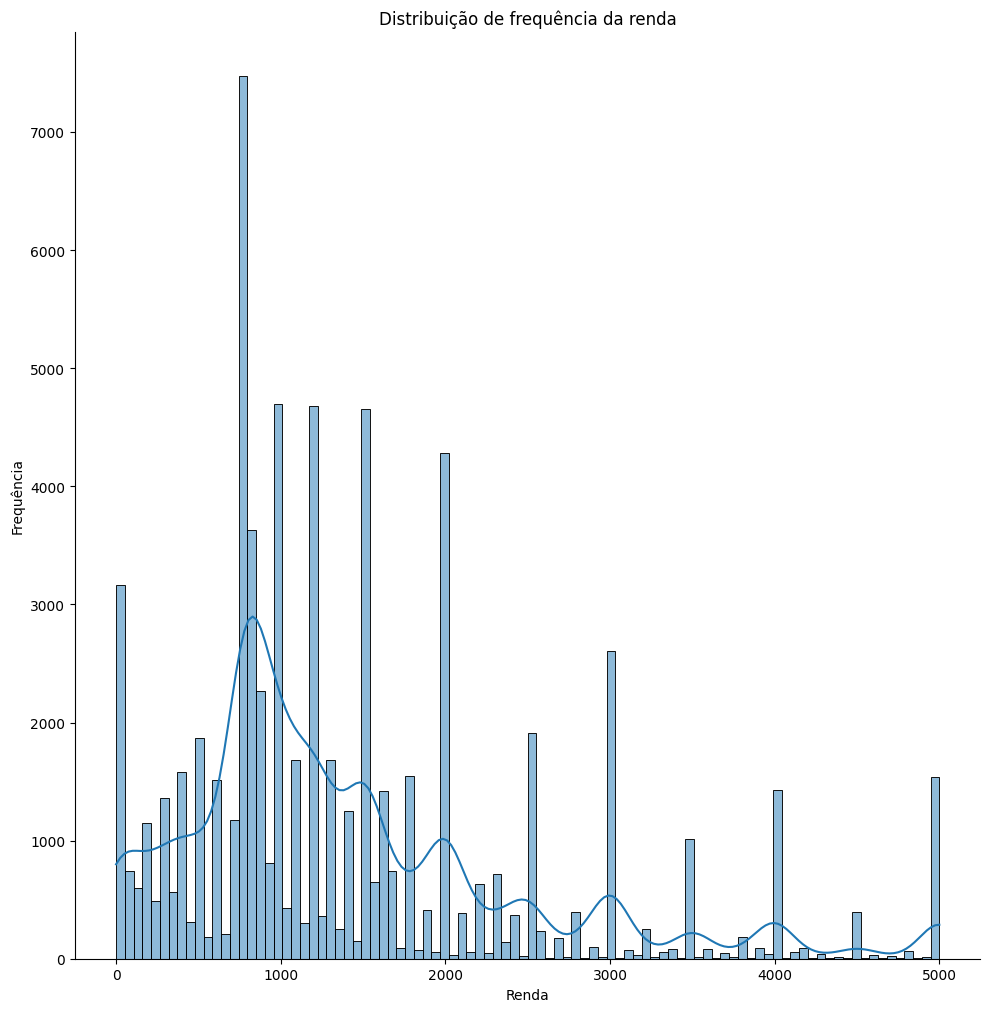

In [13]:
sns.displot(renda, kde=True, height=10)
plt.ylabel('Frequência')
plt.xlabel('Renda')
plt.title('Distribuição de frequência da renda')

In [14]:
from scipy.stats import anderson, kstest, norm

In [45]:
kstest(renda, norm.cdf)

KstestResult(statistic=0.9602404599958646, pvalue=0.0, statistic_location=5.0, statistic_sign=-1)

In [16]:
# a renda não segue uma distribuição normal
anderson(renda, dist='norm')

AndersonResult(statistic=2621.7615503014094, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=1426.5372144947232, scale=1082.7945490306845)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

### Balancemento entre sexo

In [17]:
frequencia_sexo = dados[['sexo']].value_counts().to_frame()
frequencia_sexo.reset_index(inplace = True)
frequencia_sexo.rename(columns={'count': 'frequencia'},
                       inplace=True)
frequencia_sexo

,sexo,frequencia
0,Masculino,49553
1,Feminino,22556


In [18]:
proporcao_sexo = dados[['sexo']].value_counts(normalize=True).to_frame() * 100
proporcao_sexo.reset_index(inplace = True)
proporcao_sexo.rename(columns={'proportion': 'proporcao (%)'},
                      inplace=True)
proporcao_sexo

,sexo,proporcao (%)
0,Masculino,68.719577
1,Feminino,31.280423


In [19]:
distr_sexo = pd.merge(left=frequencia_sexo, how='inner',
                      on='sexo', right=proporcao_sexo)
distr_sexo

,sexo,frequencia,proporcao (%)
0,Masculino,49553,68.719577
1,Feminino,22556,31.280423


Há um desbalancemento entre os sexo

In [20]:
renda_sexo = dados.groupby('sexo')[['sexo','renda']]

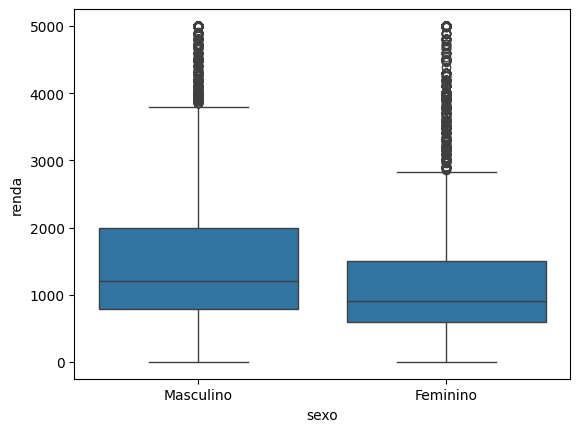

In [21]:
sns.boxplot(data=dados, x='sexo', y='renda')
plt.show("notebook")

In [22]:
renda_sexo.describe()

renda                                                        \
             count         mean          std  min    25%     50%     75%   
sexo                                                                       
Feminino   22556.0  1181.701055   994.046245  0.0  600.0   900.0  1500.0   
Masculino  49553.0  1537.984037  1103.021757  0.0  788.0  1200.0  2000.0   

                   
              max  
sexo               
Feminino   5000.0  
Masculino  5000.0

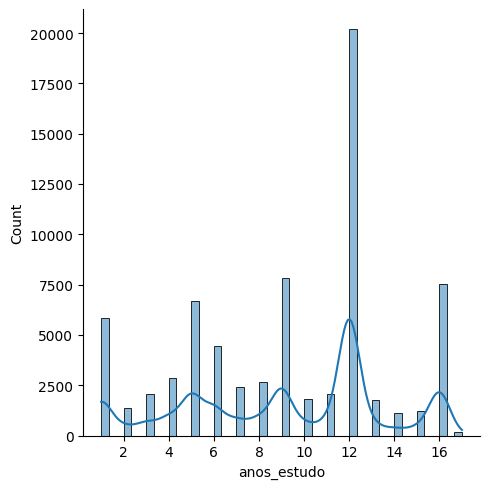

In [23]:
sns.displot(dados.anos_estudo, kde=True, height=5)

In [50]:
anos_estudo_sexo = dados.groupby('sexo')[['sexo','anos_estudo']]
anos_estudo_sexo.describe()

anos_estudo                                                 
                count       mean       std  min  25%   50%   75%   max
sexo                                                                  
Feminino      22556.0  10.023231  4.379938  1.0  6.0  12.0  12.0  17.0
Masculino     49553.0   8.733356  4.399562  1.0  5.0   9.0  12.0  17.0

In [51]:
var_coef_anos_f = 4.379938 / 10.023231
var_coef_anos_f

0.43697865488683246

In [52]:
var_coef_anos_m = 4.399562 / 8.733356
var_coef_anos_m

0.5037653337388285

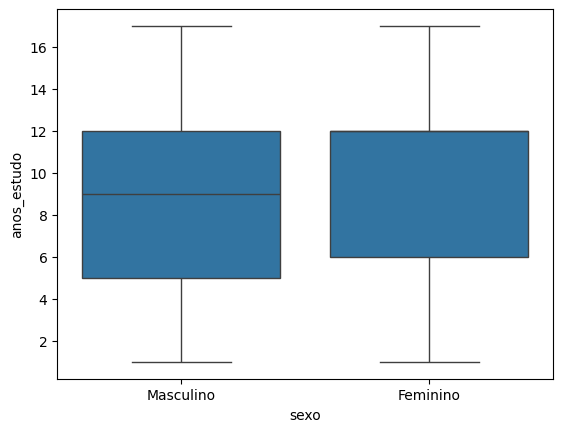

In [25]:
sns.boxplot(data=dados, x='sexo', y='anos_estudo')
plt.show("notebook")

In [26]:
# computando os limites inferior e superior do boxplot (na mão, para mostrar que sei o que to fazendo)

lim_inf_m = 2000 + 1.5*(2000 -788)
lim_sup_m = 788 - 1.5*(2000 - 788)
lim_inf_f = 1500 + 1.5*(1500 - 600)
lim_sup_f = 600 - 1.5*(1500 - 600)

In [27]:
renda_m = dados.query('sexo == "Masculino"').renda
renda_f = dados.query('sexo == "Feminino"').renda

In [28]:
media_renda_m = renda_m.mean().round(2)
media_renda_f = renda_f.mean().round(2)

In [29]:
print(
    f"Média de renda dos homens: {media_renda_m}",
    f"Média de renda das mulheres: {media_renda_f}",
    sep = "\n"
)

Média de renda dos homens: 1537.98
Média de renda das mulheres: 1181.7


### Teste de hipótese
A diferença entre as médias é significativa, a ponto indicar fortemente que há uma diferença entre as médias populacionais da renda entre os homens e as mulheres.
Para confirmar essa hipótese, utilizaremos um método baseado em dados.

Como as variâncias populacionais são desconhecidas, utilizaremos a distribuição t-student.

Considere as hipóteses abaixo.

$ H_0: \mu_1 = \mu_2$ \\
$ H_1: \mu_1 \neq \mu_2$ \\
Nível de significância $\alpha = 0.5 $

In [30]:
ttest = stats.ttest_ind(renda_m, renda_f, equal_var = False)
ttest

TtestResult(statistic=43.091614419485914, pvalue=0.0, df=48051.9701494916)

Como pvalue $ < \alpha$, há evidencias suficientes para rejeitaremos a hipótese nula.

In [31]:
ttest.confidence_interval(confidence_level=.05)

ConfidenceInterval(low=355.76451759038594, high=356.80144669317485)

In [32]:
q_25 = renda.quantile(q=.25)
q_75 = renda.quantile(q=.75)
iiq = q_75 - q_25
lim_inf = q_25 - 1.5*iiq
lim_sup = q_75 + 1.5*iiq

In [33]:
mask = (lim_inf <= renda) & (renda <= lim_sup)
dados_2 = dados[mask]

In [35]:
dados.select_dtypes(include='number').corr(method='pearson')

,idade,anos_estudo,renda,altura
idade,1.000000,-0.301891,-0.053125,-0.001253
anos_estudo,-0.301891,1.000000,0.448239,0.005731
renda,-0.053125,0.448239,1.000000,0.006117
altura,-0.001253,0.005731,0.006117,1.000000


In [36]:
# pessoas que possuem pelo menos o ensino médio completo
dados.select_dtypes(include='number')[dados.anos_estudo >= 12 ].corr()

,idade,anos_estudo,renda,altura
idade,1.000000,0.098087,0.135919,0.000709
anos_estudo,0.098087,1.000000,0.346732,0.005475
renda,0.135919,0.346732,1.000000,0.007261
altura,0.000709,0.005475,0.007261,1.000000


In [37]:
# pessoas que possuem no máximo o ensino médio incompleto
dados.select_dtypes(include='number')[dados.anos_estudo < 12 ].corr()

,idade,anos_estudo,renda,altura
idade,1.000000,-0.349097,-0.069560,0.000172
anos_estudo,-0.349097,1.000000,0.257425,-0.003564
renda,-0.069560,0.257425,1.000000,-0.000612
altura,0.000172,-0.003564,-0.000612,1.000000


In [38]:
# dados do sexo masculino
dados[dados.sexo == 'Masculino'].select_dtypes(include='number').corr()

,idade,anos_estudo,renda,altura
idade,1.000000,-0.312130,-0.051378,-0.000789
anos_estudo,-0.312130,1.000000,0.466243,0.006607
renda,-0.051378,0.466243,1.000000,0.008038
altura,-0.000789,0.006607,0.008038,1.000000


In [39]:
# dados do sexo feminino
dados[dados.sexo == 'Feminino'].select_dtypes(include='number').corr()

,idade,anos_estudo,renda,altura
idade,1.000000,-0.291420,-0.055338,-0.002359
anos_estudo,-0.291420,1.000000,0.511036,0.003187
renda,-0.055338,0.511036,1.000000,0.002726
altura,-0.002359,0.003187,0.002726,1.000000


In [40]:

dados.select_dtypes(include='number').corr()

,idade,anos_estudo,renda,altura
idade,1.000000,-0.301891,-0.053125,-0.001253
anos_estudo,-0.301891,1.000000,0.448239,0.005731
renda,-0.053125,0.448239,1.000000,0.006117
altura,-0.001253,0.005731,0.006117,1.000000


In [41]:
dados_2.select_dtypes(include='number').corr()

,idade,anos_estudo,renda,altura
idade,1.00000,-0.322010,-0.100610,-0.001030
anos_estudo,-0.32201,1.000000,0.420937,0.004285
renda,-0.10061,0.420937,1.000000,0.007181
altura,-0.00103,0.004285,0.007181,1.000000


In [44]:
anderson(dados.altura, dist='norm')

AndersonResult(statistic=0.42852610813861247, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=1.6995828213144406, scale=0.07976812932177982)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')